# INTRODUCTION

Une chaine de fleuriste aimerait pouvoir trier ses espèces d'iris. On va réaliser un programme premettant de prédire l'espèce d'une iris a partir de la longueur et la largeur de ses sépales et des pétales.

Pour cela nous disposons d'un dataset comportant des exemples d'iris labélisés. Dans un premier temps, on va faire une analyse exploratoire de ce jeu de données pour ensuite s'interesser au machine learning et à la prédiction.

### Import des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import joblib

# AED

In [2]:
df = pd.read_csv('iris.csv')
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


On a 150 fleurs différentes qui ont chacune 4 caractéristiques :
- `sepal.length (cm)`
- `sepal.width (cm)`
- `petal.length (cm)`
- `petal.width (cm)`

Chaque fleur peut appartenir à une catégorie parmi 3 :
- `setosa`
- `versicolor`
- `virginica`

#### Verification des valeurs manquantes

In [3]:
df.isnull().sum()

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64

Aucune valeur manquante, on peut poursuivre.

Voyons si notre dataset est équilibré :

In [4]:
df.value_counts('variety').to_frame()

,0
variety,
Setosa,50
Versicolor,50
Virginica,50


Toutes les espèces contiennent le même nombre de lignes, donc on peut continuer sans supprimer aucune entrée

#### Visualisation des données

- Comparaison `sepal.length` et `sepal.width`

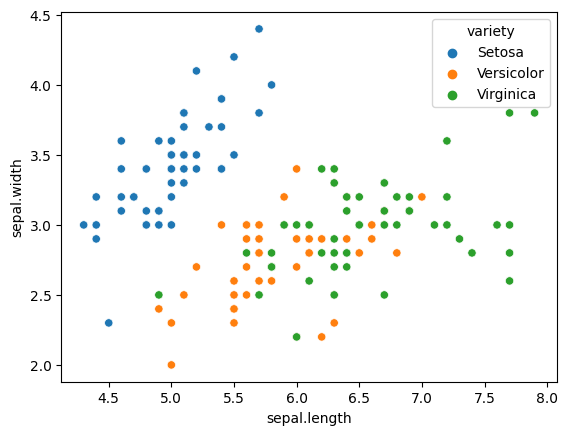

In [5]:
plt.figure()
sns.scatterplot(x='sepal.length', y='sepal.width',hue='variety', data=df)
plt.show()

#### Observations :
- Les `setosa` ont des sepals de petite longueur et de grande largeur
- Les `virginica` ont des sepals de grande longueur et de faible largeur
- Les `versicolor` sont entre les deux autres espèces

- Comparaison `petal.length` et `petal.width`

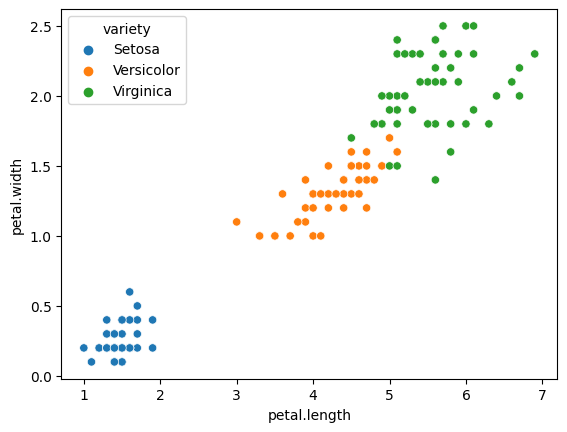

In [6]:
plt.figure()
sns.scatterplot(x='petal.length', y='petal.width',hue='variety', data=df)
plt.show()

#### Observations :
- Les `setosa` ont des petals de petite longueur et largeur
- Les `virginica` ont des petals de grande longueur et largeur
- Les `versicolor` sont entre les deux autres espèces

On peut maintenant visualiser toutes les colonnes grâce à la fonction **pairplot**

<Figure size 640x480 with 0 Axes>

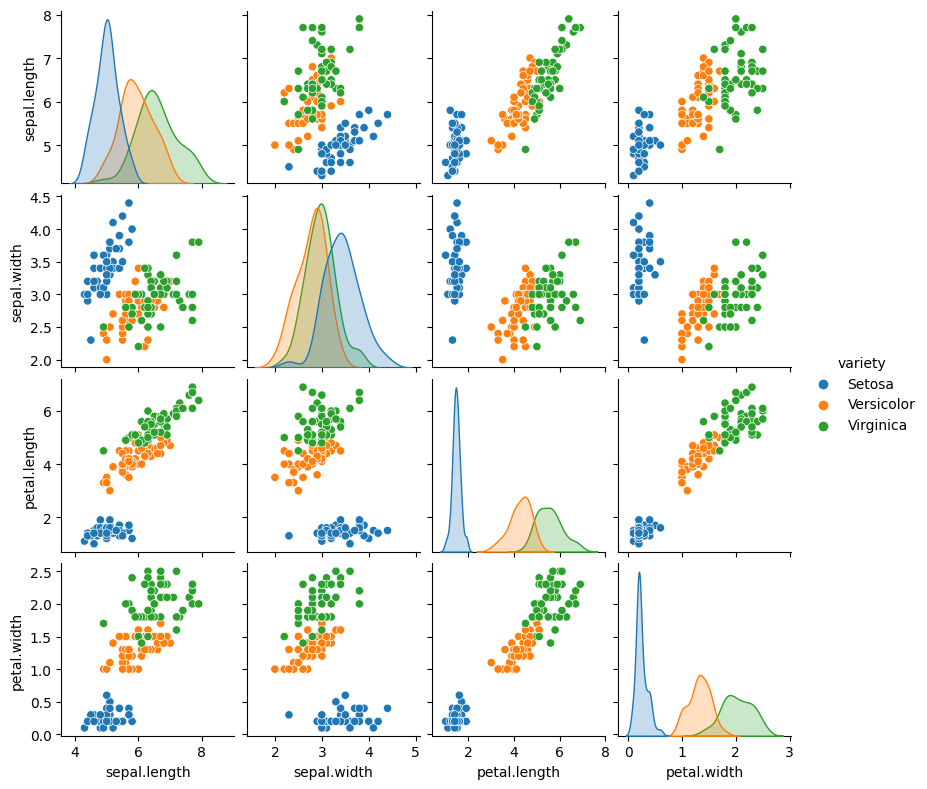

In [7]:
plt.figure()
sns.pairplot(data=df, hue='variety', height=2, diag_kind='kde')
plt.show()

On distingue qu'en terme de `petal.length` et `petal.width` on peut distinguer assez facilement les 3 espèces. Ce qui n'est pas le cas des autres features où on observe beaucoup de chevauchements.

Utiliser `petal.length` et `petal.width` pour la classification semble être une bonne initiative.

### Correlation

Pour visualiser la corrélation avec l'output il va nous falloir encoder ce dernier, on utilise LabelEncoder.

In [8]:
le = preprocessing.LabelEncoder()
df['variety'] = le.fit_transform(df['variety'])

In [9]:
joblib.dump(le, 'encoder')

['encoder']

In [10]:
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


- `variety` = 0 --> `setosa`
- `variety` = 1 --> `versicolor`
- `variety` = 2 --> `virginica`

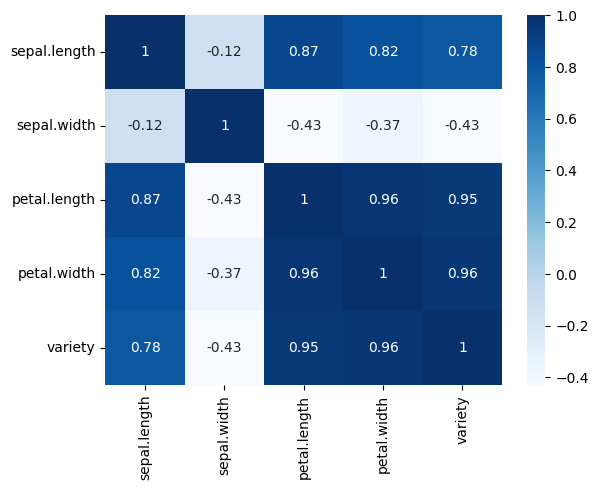

In [11]:
plt.figure()
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Certaines features ont de forte corrélations entre elles ( `petal.length` et `petal.width` / `petal.length` et `sepal.length` )

On vérifie ce qu'on a vu précedemment, `petal.length` et `petal.width` ont une forte corrélation avec `variety`

### Outliers

<AxesSubplot: xlabel='petal.width'>

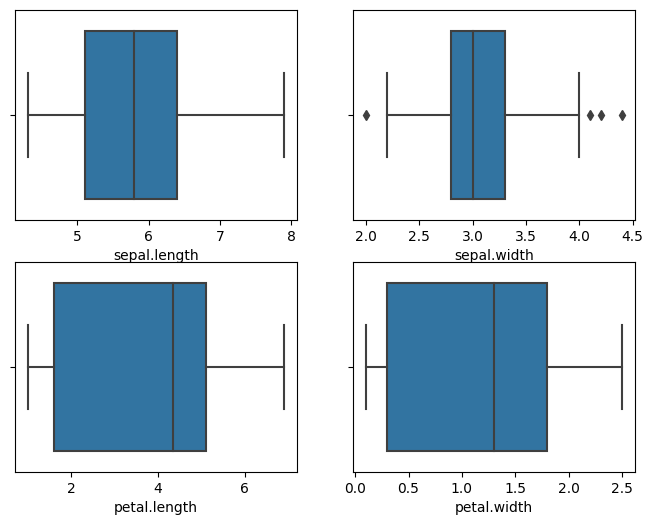

In [12]:
plt.figure(figsize=(8,6))
plt.subplot(221)
sns.boxplot(x='sepal.length', data=df)
plt.subplot(222)
sns.boxplot(x='sepal.width', data=df)
plt.subplot(223)
sns.boxplot(x='petal.length', data=df)
plt.subplot(224)
sns.boxplot(x='petal.width', data=df)

On a des valeurs abberantes dans la colonne `sepal.width`, au delà de 4 cm et en dessous et 2.25cm

In [13]:
def remove_outliers(df, col):
    """Removes outliers using the IQR method
    for the column 'col' in the dataframe 'df'"""

    #On utilise l'IQR
    Q1 = np.percentile(df[col], 25,method = 'midpoint')
    Q3 = np.percentile(df[col], 75,method = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper = np.where(df[col] >= (Q3+1.5*IQR))

    # Lower bound
    lower = np.where(df[col] <= (Q1-1.5*IQR))

    # Suppresion des Outliers
    df.drop(upper[0], inplace = True)
    df.drop(lower[0], inplace = True)

remove_outliers(df, 'sepal.width')
df.shape

(146, 5)

On a bien drop 4 valeurs. Notre dataset est propre on peut maintenant passer à l'étape du machine learning.

# Machine Learning (KNN)

On a affaire à un problème de classification, on va donc utliser KNeighbors qui un modèle simple d'utilisation pour ce genre de cas.

Mais dans un premier temps il nous faut séparer notre jeu de données en 2, une partie pour l'entrainement du modèle et l'autre pour le tester :

### train_test_split

In [14]:
y = df['variety']
X = df.drop('variety', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

Dans certains cas il peut être nécessaire de mettre à l'échelle notre dataset lorsqu'il comporte des variables très différentes.

Ici, nos 4 features sont dans le même ordre de grandeur et de la même unité (cm) mais on va tout de même le faire pour s'entrainer.

### Mise à l'échelle

In [15]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

joblib.dump(scaler, 'minmaxscaler')

['minmaxscaler']

Le modèle KNeighbors possède un hyper-paramètre n_neighbors qui définit le nombre de voisins choisis pour chaque nouvel élément à classifier

Pour définir quel K est le plus adapté on va utiliser la méthode GridSearchCV pour des K allant de 1 à 25 :

In [16]:
param_grid = {'n_neighbors': np.arange(1,25), 'metric' : ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_scale, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9478947368421053
{'metric': 'euclidean', 'n_neighbors': 5}


On peut utiliser le meilleur modèle 'grid.best_estimator_' pour la suite :

In [17]:
knn = grid.best_estimator_
knn.fit(X_train_scale, y_train)

KNeighborsClassifier(metric='euclidean')

In [18]:
joblib.dump(knn, 'final_model') #enregistrement du modèle

['final_model']

### Cross Validation

Notre modèle est désormais prêt à l'emploi on peut donc estimer sa précision en effectuant une corss validation.

On utilise la méthode StratifiedKFold car elle est la plus adaptée pour les problèmes de classification :

In [19]:
cv = StratifiedKFold(4)
print('Train score:', cross_val_score(knn, X_train_scale, y_train, cv=cv).mean())
print('Test score:', cross_val_score(knn, X_test_scale, y_test, cv=cv).mean())

Train score: 0.9379166666666667
Test score: 0.9583333333333333


### Matrice de confusion

Pour visualiser quelles erreurs de classification a effectué notre modèle on peut utiliser une matrice de confusion :

<AxesSubplot: >

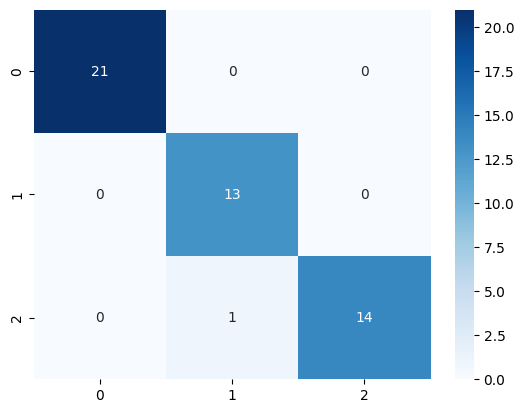

In [21]:
y_pred = knn.predict(X_test_scale)
cf_matrix = metrics.confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### Learning curve

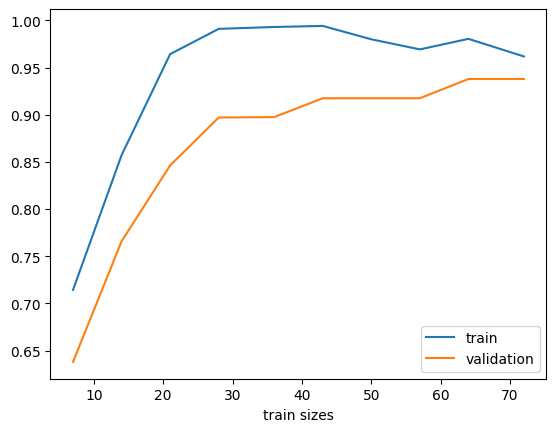

In [22]:
N, train_score, val_score = learning_curve(knn, X_train_scale, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=cv)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train sizes')
plt.legend()

Au delà de 60 élements dans notre jeu d'entrainement, les performances ne s'améliorent plus, elle commencent même a se detériorer.

On a un phénomène d'over-fitting, il faut être prudent et ne pas trop entrainer notre modèle sur la même base pour éviter qu'il soit perdu dès qu'il rencontre quelque chose de nouveau

# CONCLUSION

Notre modèle de machine learning est très performant, ce qui est logique compte tenu de la propreté de nos données. 

Maintenant pour aller plus loin, on peut essayer d'entraîner un nouveau modèle mais en supprimant nos caractéritiques fortement corrélés qu'on a pu voir. On va vérifier si cela impacte ou non nos résultats :

N.B : Certaines features ont de fortes corrélations entre elles ( `petal.length` et `petal.width` / `petal.length` et `sepal.length` )

On va conserver seulement `petal.length` et `sepal.width`

On aurait pu aussi garder uniquement `petal.length` et `petal.width` qui sont nos deux caractéristiques très fortement corrélées avec la target `variety`

In [26]:
df2 = df
df2.drop(['petal.width'], axis=1, inplace=True)
df2.drop(['sepal.length'], axis=1, inplace=True)
df2.head()

,sepal.width,petal.length,variety
0,3.5,1.4,0
1,3.0,1.4,0
2,3.2,1.3,0
3,3.1,1.5,0
4,3.6,1.4,0


Train score: 0.9275
Test score: 0.8958333333333333


<AxesSubplot: >

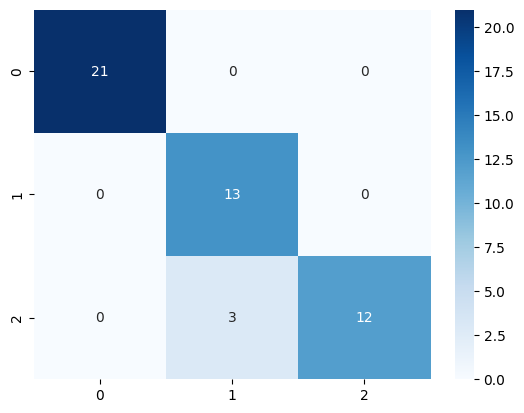

In [27]:
#train_test_split
y = df2['variety']
X = df2.drop('variety', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

#mise à l'echelle
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

#choix du meilleur hyper-paramètre
param_grid = {'n_neighbors': np.arange(1,25)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_scale, y_train)

#entrainement du modèle
knn = grid.best_estimator_
knn.fit(X_train_scale, y_train)

#cross validation
cv = StratifiedKFold(4)
print('Train score:', cross_val_score(knn, X_train_scale, y_train, cv=cv).mean())
print('Test score:', cross_val_score(knn, X_test_scale, y_test, cv=cv).mean())

#matrice de confusion
y_pred = knn.predict(X_test_scale)
cf_matrix = metrics.confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### Observations 

Avec seulement deux caractéristiques `petal.length` et `sepal.width` les résultats sont presques indentiques